In [1]:
# typical libraries...
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

# for importing and working with texts
import requests
import re
import string

# pytorch stuff
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install torchinfo # not installed by default in colab
from torchinfo import summary

from tqdm.auto import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Create Dataloader**

## Import text and create dictionary

In [3]:
# get raw text from internet
text = requests.get('https://www.gutenberg.org/files/35/35-0.txt').text
# character strings to replace with space
strings2replace = [ '\r\n\r\nâ\x80\x9c','â\x80\x9c','â\x80\x9d','\r\n','â\x80\x94','â\x80\x99','â\x80\x98','_', ]

# use regular expression (re) to replace those strings with space
for str2match in strings2replace:
  text = re.compile(r'%s'%str2match).sub(' ',text)

# remove non-ASCII characters and numbers, and make lower-case
text = re.sub(r'[^\x00-\x7F]+', ' ', text)
text = re.sub(r'\d+','',text).lower()

# split into words with >1 letter
words = re.split(r'['+re.escape(string.punctuation)+r'\s]+',text)
words = [item.strip() for item in words if item.strip()]
words = [item for item in words if len(item)>1]

# create the vocabulary (lexicon)
vocab  = sorted(set(words))
nWords = len(words)
nVocab = len(vocab)

# encoder/decoder look-up-tables (as python dictionaries)
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}

# show a few keys in the dictionary
print(f'The book contains {nWords:,} words, {nVocab:,} of which are unique and comprise the vocab.')
print(f'\n\nFirst 10 vocab words:\n',list(word2idx.keys())[:10])

The book contains 30,698 words, 4,589 of which are unique and comprise the vocab.


First 10 vocab words:
 ['abandon', 'abandoned', 'able', 'abnormally', 'abominable', 'abominations', 'about', 'above', 'abruptly', 'absence']


In [4]:
# parameters for dataset
context_length = 8 # context length
stride = 2 # skipping

# initialize
inputs  = []
targets = []

# overlapping sequences of context_length
for i in range(0,nWords-context_length,stride):

  # get a few words
  in_seq   = words[i  : i+context_length  ]
  targ_seq = words[i+1: i+context_length+1]

  # append to the lists
  inputs.append([word2idx[w] for w in in_seq])
  targets.append([word2idx[w] for w in targ_seq])

print(inputs[123])
print(targets[123])

[1342, 4304, 4119, 342, 4296, 3388, 1474, 131]
[4304, 4119, 342, 4296, 3388, 1474, 131, 209]


In [5]:
# a closer look:
print('Inputs: ',inputs[4])
print('Targets:',targets[4])
print('')
print('Inputs :',inputs[5])
print('Targets:',targets[5])

Inputs:  [2416, 131, 2172, 506, 4451, 783, 2167, 2005]
Targets: [131, 2172, 506, 4451, 783, 2167, 2005, 4042]

Inputs : [2172, 506, 4451, 783, 2167, 2005, 4042, 2416]
Targets: [506, 4451, 783, 2167, 2005, 4042, 2416, 2006]


## Create a class for a dataset object

In [6]:
# create a class for a dataset
class WordDataset(Dataset):
  def __init__(self, text, word2idx, context_length=8, stride=4):

    # initialize
    self.inputs  = []
    self.targets = []
    self.word2idx = word2idx  # stored locally in the object

    # overlapping sequences of context_length
    for i in range(0,len(text)-context_length, stride):

      # get a few words
      in_seq   = text[i : i+context_length]
      targ_word = text[i+context_length]

      # append to the lists
      self.inputs.append(torch.tensor([word2idx[w] for w in in_seq]))
      self.targets.append(torch.tensor(word2idx[targ_word]))

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]


# create an instance!
context_length = 6 # context length
stride = 3 # skipping over tokens
text_dataset = WordDataset(words,word2idx,context_length,stride)

print(f'Inputs: {text_dataset.inputs[123]}\n')
print(f'Outputa: {text_dataset.targets[123]}\n')

Inputs: tensor([ 255,   96, 1861, 3176, 1338, 1474])

Outputa: 332



## Create a dataloader for training

In [7]:
dataloader = DataLoader(
                text_dataset,
                batch_size = 32,
                shuffle    = True,
                drop_last  = True
            )

# let's have a look at the indices
X,y = next(iter(dataloader))
print('Inputs:')
print(X), print('')

print('Targets:')
print(y), print('\n\n\n')

# and the words
print('Inputs in words (first batch):')
print([idx2word[item.item()] for item in X[0]])
print('')

print('Targets in words (first batch):')
print([idx2word[item.item()] for item in y])

Inputs:
tensor([[ 333, 2608, 1890, 4408, 3831, 2817],
        [ 897,  367, 2470, 4119, 4042, 4450],
        [1297, 4516, 1275, 2459, 2003, 2744],
        [2395, 2187, 4034,  255, 2303, 4549],
        [1789, 2037, 1694, 4119,  959, 2519],
        [2572, 3916, 4445,  519, 4352,  677],
        [4461, 1304, 2183,  706,  137,  661],
        [1353,  230, 2574, 4509,  817, 2171],
        [ 255, 4537, 4296, 4073, 1690, 2731],
        [   9, 2731, 2435,  137, 2041, 4016],
        [2347, 4502, 3758,  501, 4042, 4503],
        [ 581, 2971, 4581, 1572, 4042, 2368],
        [1479, 4463,  817, 3636, 2387, 1572],
        [2731, 4042, 3696, 1226, 2041, 4466],
        [4108, 4334, 4125, 4073, 4064, 2791],
        [3427, 2887, 3055, 4042, 4109, 4171],
        [2685,  550,  435, 1972,  137, 2608],
        [3507, 2238, 1122,  137, 2338, 1901],
        [ 314, 3150, 1815, 2911, 4041, 2003],
        [1867, 4047, 1402,  137, 1299, 1402],
        [2731, 4042, 4109, 2416, 3388,  137],
        [2999, 2041,  809,

In [8]:
# Exploring the dimensionality of embeddings vector based on vocab sizes

# vocab sizes
N = np.logspace(start=np.log10(1000), stop=np.log10(100000), num=23, dtype=int)

embeddings_dim = np.sqrt(N)

## Build the model

In [9]:
class embedding_model(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_size):
    super().__init__()

    # Embedding Layer
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    # Linear Layer
    self.linear1 = nn.Linear(context_size * embedding_dim, 128)
    self.linear2 = nn.Linear(128, vocab_size)

  def forward(self, x):
    embeds = self.embeddings(x).view(x.shape[0],-1)

    out = F.relu(self.linear1(embeds))
    out = self.linear2(out)

    log_probs = F.log_softmax(out, dim=1)

    return log_probs

In [10]:
# Instantiate the model
embedding_dim = 100
model = embedding_model(vocab_size=nVocab, embedding_dim=embedding_dim, context_size=context_length)
print(model)

embedding_model(
  (embeddings): Embedding(4589, 100)
  (linear1): Linear(in_features=600, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=4589, bias=True)
)


In [11]:
# Apply Xavier weight distribution
for p in model.parameters():
  if p.dim()>1:
    nn.init.xavier_normal_(p)

In [12]:
# Test the model
X, y = next(iter(dataloader))
model_out = model(X)

print('Input to model:')
print(X), print(' ')

print(f'Outup from model (size: {list(model_out.shape)}):')
print(model_out), print(' ')

print(model_out.detach()[0])

Input to model:
tensor([[2780, 2000,  204, 4318,  137, 4026],
        [2731, 4042, 3301,  365, 2608, 1450],
        [3840, 4510, 2608,  286, 4119, 4177],
        [4554, 1572, 4042, 1953,  927, 2731],
        [4510, 3041,    9, 2731,  579, 4058],
        [1815,  112,  158, 4041, 4042, 2887],
        [3805, 2783, 2041, 4042, 1187, 2573],
        [2608, 2647, 4125, 2609, 4041,  817],
        [4042,   20, 1494,  137, 4058, 3218],
        [3387, 2459, 4041, 3831, 3243, 4119],
        [ 137,   96, 4042, 4148, 2731, 2334],
        [ 501, 4041, 4042, 2602, 4408,  486],
        [1944, 4119, 4466,  689, 1815, 4119],
        [4092, 4042, 2318, 3849, 4408, 3470],
        [4428,  204,  255, 3027, 1267,  137],
        [3734, 3497, 2608, 4009,  137,   74],
        [2740, 3149, 2944, 2041, 4042,  809],
        [3172, 3000, 1419, 3170, 1361, 4549],
        [ 137, 4510, 1929, 1835,  942, 2041],
        [1388, 3253, 2470, 2731, 4042, 2569],
        [4077, 4042, 3995, 1675, 2332, 1572],
        [4042, 299

In [13]:
summary(model=model,
        input_size=(32, context_length),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=30,
        row_settings=["var_names"],
        dtypes=[torch.long]
)

Layer (type (var_name))                  Input Shape                    Output Shape                   Param #                        Trainable
embedding_model (embedding_model)        [32, 6]                        [32, 4589]                     --                             True
├─Embedding (embeddings)                 [32, 6]                        [32, 6, 100]                   458,900                        True
├─Linear (linear1)                       [32, 600]                      [32, 128]                      76,928                         True
├─Linear (linear2)                       [32, 128]                      [32, 4589]                     591,981                        True
Total params: 1,127,809
Trainable params: 1,127,809
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 36.09
Input size (MB): 0.00
Forward/backward pass size (MB): 1.36
Params size (MB): 4.51
Estimated Total Size (MB): 5.87

In [14]:
# Re-Instantiate the model and move to GPU
nVocab = len(vocab)
embedding_dim = 100
context_length = 6
model = embedding_model(vocab_size=nVocab, embedding_dim=embedding_dim, context_size=context_length)
model.to(device=device)
print(model)

embedding_model(
  (embeddings): Embedding(4589, 100)
  (linear1): Linear(in_features=600, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=4589, bias=True)
)


In [15]:
# Apply Xavier weight distribution to initialize the weights
for p in model.parameters():
  if p.dim()>1:
    nn.init.xavier_normal_(p)

In [16]:
# Define the loss and optimizer functions
loss_func = nn.NLLLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-1)

In [17]:
# Get the weights from the pre-tarined model
pretrained_weights = model.embeddings.weight.detach().cpu()
pretrained_weights

tensor([[-0.0030,  0.0054, -0.0139,  ...,  0.0251, -0.0192,  0.0240],
        [-0.0048, -0.0132,  0.0070,  ...,  0.0251,  0.0018, -0.0007],
        [-0.0058,  0.0138, -0.0024,  ..., -0.0235, -0.0214,  0.0178],
        ...,
        [-0.0012,  0.0201, -0.0011,  ..., -0.0018,  0.0021, -0.0082],
        [ 0.0102,  0.0157,  0.0065,  ..., -0.0194, -0.0093,  0.0132],
        [-0.0263,  0.0084, -0.0151,  ..., -0.0302, -0.0051,  0.0054]])

## Train the model

In [18]:
def train_model(numepochs=25):
  model.to(device)

  model.train()

  epoch_losses = []

  # Get the tqdm object for the epoch loop
  epoch_pbar = tqdm(range(numepochs), desc='Epochs', leave=True)

  for i in epoch_pbar:
    batch_loss = []

    # Get the tqdm object for the batch loop, with leave=True to show it
    batch_pbar = tqdm(dataloader, desc=f'Epoch {i} Batch', leave=True)

    for X,y in batch_pbar:

      # Move the data to the GPU
      X = X.to(device)
      y = y.to(device)

      # zero the gradients
      model.zero_grad()

      # forward pass
      y_hat = model(X)

      # compute the loss
      loss = loss_func(y_hat,y.flatten())
      batch_loss.append(loss.item())

      # backward pass
      loss.backward()

      # update the weights
      optimizer.step()

      # Update postfix of batch tqdm
      batch_pbar.set_postfix(loss=f'{loss.item():.4f}')

    # current_epoch_loss = np.mean(batch_loss)
    current_epoch_loss = batch_loss[-1]
    epoch_losses.append(current_epoch_loss)

    # Update the postfix of the epoch tqdm bar
    epoch_pbar.set_postfix(loss=f'{current_epoch_loss:.4f}')

  return epoch_losses

In [19]:
epoch_losses = train_model(numepochs=25)


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 1 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 2 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 3 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 4 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 5 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 6 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 7 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 8 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 9 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 10 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 11 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 12 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 13 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 14 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 15 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 16 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 17 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 18 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 19 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 20 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 21 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 22 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 23 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 24 Batch:   0%|          | 0/319 [00:00<?, ?it/s]

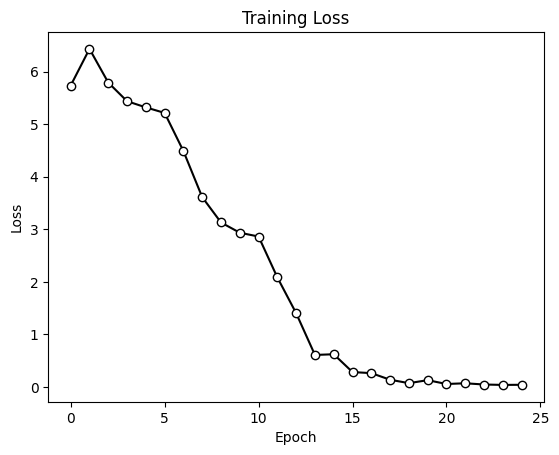

In [20]:
# Plot the losses over epochs
plt.plot(epoch_losses, 'ko-', markerfacecolor='w')
plt.gca().set(xlabel='Epoch', ylabel='Loss', title='Training Loss')
plt.show()

In [21]:
# Check the embedding weights post training
posttrained_weights = model.embeddings.weight.detach().cpu()
posttrained_weights

tensor([[-0.1378, -0.0751,  0.0348,  ..., -0.1168, -0.0498,  0.0774],
        [-0.0762, -0.0629,  0.0491,  ...,  0.0461,  0.1550, -0.1584],
        [-0.1147, -0.0565,  0.0938,  ..., -0.0930, -0.1872,  0.1309],
        ...,
        [-0.1336, -0.0864,  0.0725,  ..., -0.0867, -0.1842,  0.1596],
        [-0.0521, -0.0593, -0.0410,  ..., -0.0487, -0.0801,  0.0383],
        [-0.0720, -0.1526,  0.1395,  ..., -0.0630, -0.0644,  0.0266]])

In [22]:
dataloader.dataset.inputs[123]

tensor([ 255,   96, 1861, 3176, 1338, 1474])

In [23]:
# Test the model
X = dataloader.dataset.inputs[123].detach().clone().unsqueeze(0).to(device)
torch.inference_mode()
model.eval()

y = model(X)
print('Inputs:')
print(X), print('')

print('Output:')
print(y), print('\n\n\n')

# and the words
print('Inputs in words (first batch):')
print([idx2word[item.item()] for item in X[0]])
print('')

print('Targets in words (first batch):')
print([idx2word[item.item()] for item in torch.argmax(y, dim=1)])

Inputs:
tensor([[ 255,   96, 1861, 3176, 1338, 1474]], device='cuda:0')

Output:
tensor([[-25.4085, -37.3561, -24.0735,  ..., -36.4385, -27.9979, -36.1875]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)




Inputs in words (first batch):
['at', 'all', 'have', 'real', 'existence', 'filby']

Targets in words (first batch):
['became']


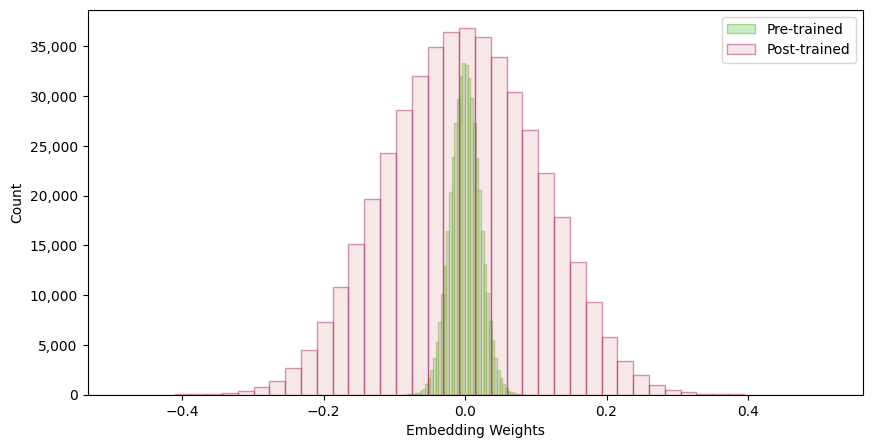

In [24]:
yPre, xPre = np.histogram(pretrained_weights.flatten(), bins=50)
yPost, xPost = np.histogram(posttrained_weights.flatten(), bins=50)

# Recalculate the values as bin centers
xPre = (xPre[1:] + xPre[:-1]) / 2
xPost = (xPost[1:] + xPost[:-1]) / 2

xLim = [min(np.min(xPre), np.min(xPost)), max(np.max(xPre), np.max(xPost))]

plt.figure(figsize=(10,5))
plt.bar(xPre, yPre, width=xPre[1]-xPre[0],color=[.7,.9,.7,.7],edgecolor=[.3,.6,0,.4],label='Pre-trained')
plt.bar(xPost, yPost, width=xPost[1]-xPost[0], color=[.9,.7,.7,.3],edgecolor=[.6,0,.3,.4],label='Post-trained')
plt.gca().set(xlabel="Embedding Weights", ylabel="Count", xlim=xLim)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.show()

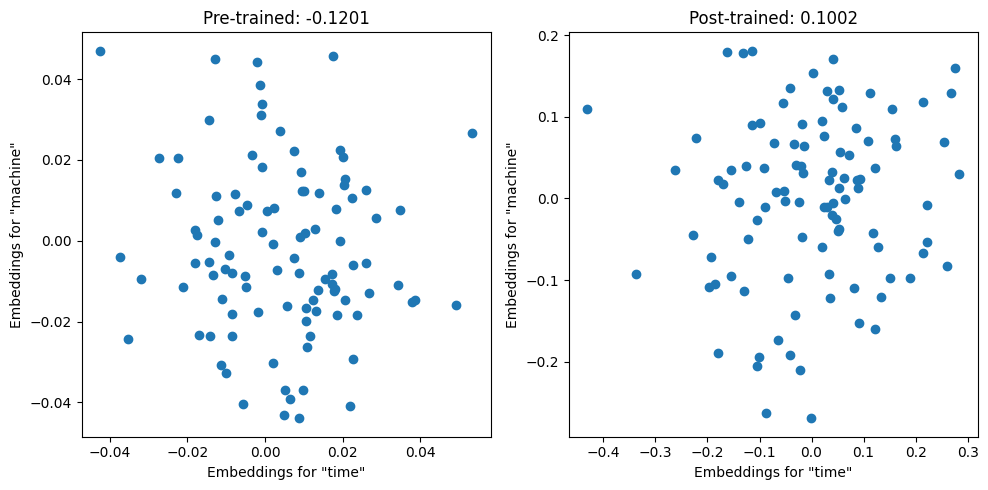

In [25]:
from requests.api import post
# Plot the cosine similarities of embeddings for the words "time" and "machine" using pre-trained and post-trained weights

word1, word2 = "time", "machine"
word1_idx = word2idx[word1]
word2_idx = word2idx[word2]

pretrained_weights_word1 = pretrained_weights[word1_idx]
pretrained_weights_word2 = pretrained_weights[word2_idx]

posttrained_weights_word1 = posttrained_weights[word1_idx]
posttrained_weights_word2 = posttrained_weights[word2_idx]

# Find cosine similarity of the words in the pre-trained and post-trained model
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
pretrained_cos = cos(pretrained_weights_word1, pretrained_weights_word2)
posttrained_cos = cos(posttrained_weights_word1, posttrained_weights_word2)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(pretrained_weights_word1, pretrained_weights_word2)
ax[0].set_title(f'Pre-trained: {pretrained_cos:.4f}')
ax[0].set(xlabel="Embeddings for \"time\"", ylabel="Embeddings for \"machine\"")

ax[1].scatter(posttrained_weights_word1, posttrained_weights_word2)
ax[1].set_title(f'Post-trained: {posttrained_cos:.4f}')
ax[1].set(xlabel="Embeddings for \"time\"", ylabel="Embeddings for \"machine\"")

plt.tight_layout()
plt.show()

In [26]:
# Manually calculate cosine similairty of pre-trained and post-trained weights for "time" and "machine"

num = torch.dot(pretrained_weights_word1, pretrained_weights_word2)
denom = torch.norm(pretrained_weights_word1) * torch.norm(pretrained_weights_word2)
pretrained_cos = num / denom
print(f'Pre-trained: {pretrained_cos:.4f}')

num = torch.dot(posttrained_weights_word1, posttrained_weights_word2)
denom = torch.norm(posttrained_weights_word1) * torch.norm(posttrained_weights_word2)
posttrained_cos = num / denom
print(f'Post-trained: {posttrained_cos:.4f}')

Pre-trained: -0.1201
Post-trained: 0.1002
